A notebook containing a minimum working example of the HSGP on synthetic data

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import pandas as pd
from gpflow.config import default_jitter
tf.config.run_functions_eagerly(True)

import ensembles as es
from ensembles import HSGP

Load model data

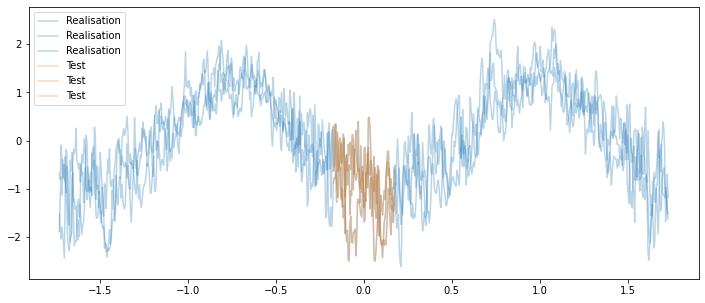

In [47]:
model = 'CESM'
df = pd.read_csv(f'./../nbs/data/SingLoc_{model}.csv')[:365 * 2]

n_realisations = 3
test_frac = 0.1

X = np.arange(len(df)).reshape(-1, 1)
X = (X - X.mean()) / X.std()
Y = df[df.columns[1: n_realisations + 1]].values
Y = (Y - Y.mean()) / Y.std()
test_lims = [round(len(X) * (0.5 - test_frac / 2)), round(len(X) * (0.5 + test_frac / 2))]

X_train = np.vstack([X[:test_lims[0]], X[test_lims[1]:]])
X_test = X[test_lims[0]: test_lims[1]]

Y_train = np.vstack([Y[:test_lims[0]], Y[test_lims[1]:]])
Y_test = Y[test_lims[0]: test_lims[1]]


plt.figure(figsize=(12, 5))
plt.plot(X, Y, alpha=0.3, color='tab:blue', label='Realisation')
plt.plot(X_test, Y_test, alpha=0.3, color='tab:orange', label='Test')


plt.legend()
# plt.xlim([0, 0.1])
plt.show()



Initialise the Hierarchical Sparse Gaussian Process (HSGP), providing the group and individual kernels, inducing points and data

In [48]:
data = (X, Y)

n_years = len(X) // 356

# Create kernel
# # Expect group kernel to have periodicity and long term changes
# group_kernel = periodic_kernel + long_kernel
# # Expect individual kernel to have short term changes and noise
# individual_kernel = short_kernel + noise_kernel

# group_kernel.kernels[0].period.assign(3.5 / n_years) # This is roughly 365 days
# group_kernel.kernels[1].lengthscales.assign(30 * 3.5 / n_years) # Roughly a climatological lengthscale 

# individual_kernel.kernels[0].lengthscales.assign(0.5 * 3.5 / n_years) # Short, seasonal lengthscale

# Create kernel
base_kernel = gpflow.kernels.Matern32()
periodic_kernel = gpflow.kernels.Periodic(base_kernel)
# long_kernel = gpflow.kernels.SquaredExponential()
short_kernel = gpflow.kernels.RationalQuadratic()
noise_kernel = gpflow.kernels.White()
# gpflow.kernels.ArcCosine

# kernel = periodic_kernel + long_kernel + short_kernel + noise_kernel
kernel = periodic_kernel + short_kernel #+ noise_kernel
kernel.kernels[0].period.assign(3.5 / n_years) # This is roughly 365 days
# kernel.kernels[1].lengthscales.assign(30 * 3.5 / n_years) # Roughly a climatological lengthscale 
# kernel.kernels[2].lengthscales.assign(0.5 * 3.5 / n_years) # Short, seasonal lengthscale
kernel.kernels[1].lengthscales.assign(0.5 * 3.5 / n_years) # Short, seasonal lengthscale
for i in range(len(kernel.kernels)):
    try:
        kernel.kernels[i].variance.assign(0.1)
    except AttributeError:
        print()

gpflow.utilities.set_trainable(kernel.kernels[0].period, False)

n_inducing = 25
Z = np.vstack([
    np.linspace(np.min(X), X[test_lims[0]], n_inducing // 2),
    np.linspace(X[test_lims[1]], np.max(X), n_inducing // 2),
]).reshape(-1,1)

hsgp = HSGP(
    (X_train, Y_train), 
    group_kernel=kernel,
    individual_kernel=kernel,
    inducing_points=Z,
    noise_variance=0.01)

gpflow.utilities.set_trainable(hsgp.inducing_points, False)

gpflow.utilities.print_summary(hsgp, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
HSGP.inducing_points.Z,Parameter,Identity,,False,"(24, 1)",float64,[[-1.72967976...
HSGP.K_group.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.0
HSGP.K_group.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
HSGP.K_group.kernels[0].period,Parameter,Softplus,,False,(),float64,1.75
HSGP.K_group.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.10000000000000002
HSGP.K_group.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.875
HSGP.K_group.kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
HSGP.K_individual_list[0].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.0
HSGP.K_individual_list[0].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
HSGP.K_individual_list[0].kernels[0].period,Parameter,Softplus,,False,(),float64,1.75


What's the prior group prediction look like?

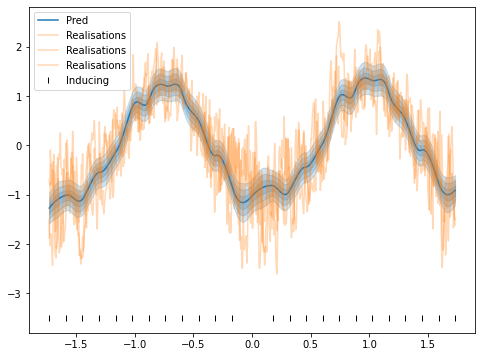

In [49]:
group_mean, group_var = hsgp.predict_group(X)
group_mean = group_mean.numpy().squeeze()
group_std = np.sqrt(group_var.numpy().squeeze())
x = X.squeeze()


plt.figure(figsize=(8, 6))
for j in range(1,4):
    plt.fill_between(x, group_mean - j * group_std, group_mean + j * group_std, alpha=0.2, color='tab:blue')
plt.plot(x, group_mean, color='tab:blue', label='Pred') 
plt.plot(X, Y, alpha=0.3, color='tab:orange', label='Realisations')
plt.plot(Z.squeeze(), [-3.5] * len(Z.squeeze()), '|', color='black', label='Inducing')
plt.legend()
plt.show()

Fit the HSGP

In [50]:
params = es.SGPRParameters().to_dict()
params['learning_rate'] = 0.05
params['optim_nits'] = 1000

# tf.config.run_functions_eagerly(True)
tf.config.run_functions_eagerly(False)
hsgp.fit(params, compile=False)
tf.config.run_functions_eagerly(True)

100%|██████████| 1000/1000 [18:50<00:00,  1.13s/it, ELBO=8.11e+3]


Check convergence of the ELBO term

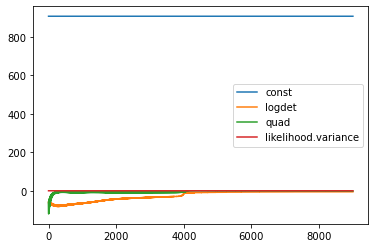

In [51]:
plt.figure()
plt.plot(hsgp.consts, label='const')
plt.plot(hsgp.logdets, label='logdet')
plt.plot(hsgp.quads, label='quad')
plt.plot(hsgp.likelihoodvars, label='likelihood.variance')

# plt.yscale('log')
plt.legend()
plt.show()


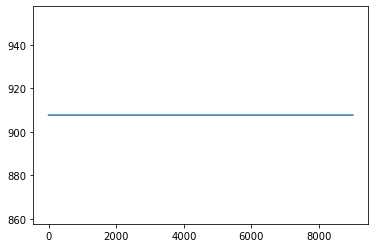

In [52]:
plt.plot(hsgp.consts, label='const')

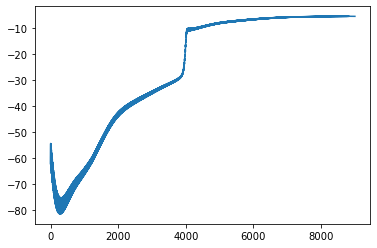

In [53]:
plt.plot(hsgp.logdets, label='logdet')


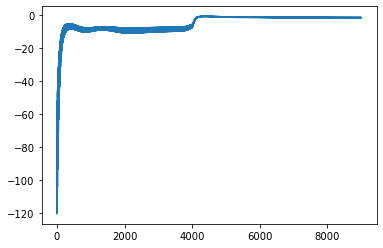

In [54]:
plt.plot(hsgp.quads, label='quad')

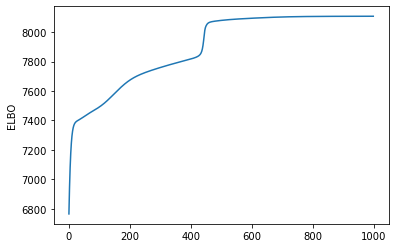

In [55]:
plt.figure()
plt.plot(-np.asarray(hsgp.objective_evals))
plt.ylabel('ELBO')
plt.show()

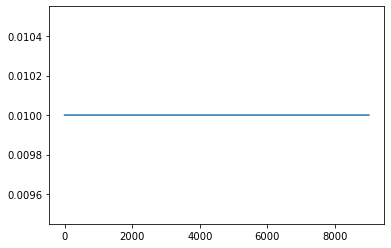

In [56]:
plt.plot(hsgp.likelihoodvars, label='likelihood.variance')

In [57]:
indi_preds = [hsgp.predict_individual(X, idx) for idx in range(n_realisations)]

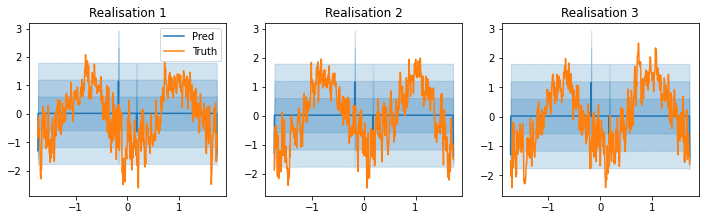

In [58]:
plt.figure(figsize=(12,7))
for i, indi_pred in enumerate(indi_preds):
    indi_mean, indi_var = indi_pred
    indi_mean = indi_mean.numpy().squeeze()
    indi_std = np.sqrt(indi_var.numpy().squeeze())
    x = X.squeeze()
    plt.subplot(2, 3, i + 1)
    plt.title(f'Realisation {i+1}')
    for j in range(1,4):
        plt.fill_between(x, indi_mean - j * indi_std, indi_mean + j * indi_std, alpha=0.2, color='tab:blue')
    plt.plot(x, indi_mean, label='Pred', color='tab:blue')
    plt.plot(x, Y[:, i], label='Truth', color='tab:orange')
    if i == 0:
        plt.legend()
    # plt.xlim([0, 1])

plt.show()

What does the group prediction look like?

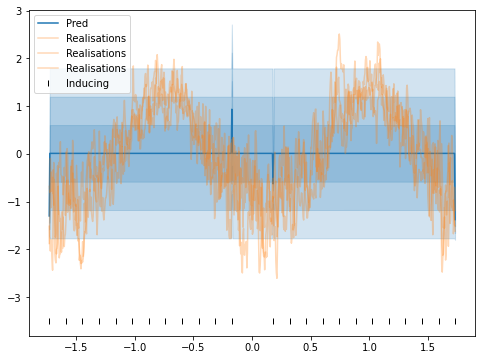

In [59]:
group_mean, group_var = hsgp.predict_group(X)
group_mean = group_mean.numpy().squeeze()
group_std = np.sqrt(group_var.numpy().squeeze())
x = X.squeeze()

plt.figure(figsize=(8, 6))
for j in range(1,4):
    plt.fill_between(x, group_mean - j * group_std, group_mean + j * group_std, alpha=0.2, color='tab:blue')
plt.plot(x, group_mean, color='tab:blue', label='Pred') 
plt.plot(X, Y, alpha=0.3, color='tab:orange', label='Realisations')
plt.plot(Z.squeeze(), [-3.5] * len(Z.squeeze()), '|', color='black', label='Inducing')
# plt.xlim([0, 1])
plt.legend()
plt.show()

In [60]:
gpflow.utilities.print_summary(hsgp, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
HSGP.inducing_points.Z,Parameter,Identity,,False,"(24, 1)",float64,[[-1.72967976...
HSGP.K_group.kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.00018243326413178585
HSGP.K_group.kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.471300767590775
HSGP.K_group.kernels[0].period,Parameter,Softplus,,False,(),float64,1.75
HSGP.K_group.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.3418630101033177
HSGP.K_group.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,6.619406270141883e-07
HSGP.K_group.kernels[1].alpha,Parameter,Softplus,,True,(),float64,0.9671007820689521
HSGP.K_individual_list[0].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,5.490487870639332e-05
HSGP.K_individual_list[0].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.58894140795855
HSGP.K_individual_list[0].kernels[0].period,Parameter,Softplus,,False,(),float64,1.75


In [ ]:
a = 1